In [11]:
import networkx as nx
import seaborn as sns
from pathlib import Path
import torch
from DQN import DQN_agent_modular
from envs.GraphEnv.impnode import ImpnodeEnv
from DQN.train_dqn import train_dqn, fill_memory
from DQN.finetune_dqn import finetune_dqn, finetune_dqn_eps, finetune_dqn_new
from DQN.test_and_compare import test_loop, hda
import matplotlib.pyplot as plt
import time
import mlflow
import  numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('finetune_experiments_base_er')

<Experiment: artifact_location='file:///C:/rituja_git/ma-rituja-pardhi/mlruns/7', creation_time=1713768292181, experiment_id='7', last_update_time=1713768292181, lifecycle_stage='active', name='finetune_experiments_base_er', tags={}>

In [13]:
import random

seed = 412
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms(True,warn_only=True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [14]:
def plot_sns(sum_reward_histories, style="classic", plot_size=(10, 8)):
    with plt.style.context(style=style):
        fig, ax = plt.subplots(figsize=plot_size)
        sns.lineplot({'ImpNode_ANC':sum_reward_histories[0], 'ImpNode_ANC_finetune':sum_reward_histories[1]})
        
        ax.set_title("cumulative sum of rewards", fontsize=14)
        ax.set_xlabel("num nodes removed", fontsize=12)
        ax.set_ylabel("reward", fontsize=12)
        for i in ax.get_xticklabels() + ax.get_yticklabels():
            i.set_fontsize(10)
        ax.legend_.remove()
        plt.tight_layout()
    plt.close(fig)
    return fig

In [15]:
def plot_sns2(ep_score_history2, style="classic", plot_size=(10, 8)):
    with plt.style.context(style=style):
        fig, ax = plt.subplots(figsize=plot_size)
        sns.boxplot(ep_score_history2)
        
        ax.set_title("validation on BA graphs", fontsize=14)
        ax.set_xlabel("_", fontsize=12)
        ax.set_ylabel("anc", fontsize=12)
        for i in ax.get_xticklabels() + ax.get_yticklabels():
            i.set_fontsize(10)
        #ax.legend_.remove()
        plt.tight_layout()
    plt.close(fig)
    return fig

In [16]:
def test(model_name, RESULTS_BASEPATH_TEST, device):
    subdir = 'data/real/Cost'
    file_name = 'BA_degree.gml'
    data_path = Path.cwd()/subdir
    max_removed_nodes = None
    NUM_TEST_EPS = 1 # number of test episodes to run
    
    
    env_test = ImpnodeEnv(anc='dw_nd', g_type='barabasi_albert', num_nodes=(30, 50), data_path=data_path,mode='test',  file_name=file_name, max_removed_nodes=max_removed_nodes)
    
    dqn_agent_test = DQN_agent_modular.DQNAgent(device=device,
                                                alpha=0.001,
                                        gnn_depth=4,
                                        state_size=2,
                                        hidden_size1=32,
                                        hidden_size2=64,
                                        action_size=1,
                                        discount=0.0,
                                        eps_max=0.0,
                                        eps_min=0.0,
                                        eps_step=0.0,
                                        memory_capacity=0,
                                        lr=0,
                                        mode='test')
    
    dqn_agent_test.load_model('{}/model.pt'.format(RESULTS_BASEPATH_TEST))
    
    actions, reward_history, ep_score_history = test_loop(env=env_test,
                                                            agent=dqn_agent_test,
                                                            NUM_TEST_EPS = NUM_TEST_EPS)
    
    dqn_agent_test_finetuned = DQN_agent_modular.DQNAgent(device=device,
                                                alpha=0.001,
                                        gnn_depth=4,
                                        state_size=2,
                                        hidden_size1=32,
                                        hidden_size2=64,
                                        action_size=1,
                                        discount=0.0,
                                        eps_max=0.0,
                                        eps_min=0.0,
                                        eps_step=0.0,
                                        memory_capacity=0,
                                        lr=0,
                                        mode='test')
    
    dqn_agent_test_finetuned.load_model('{}/{}.pt'.format(RESULTS_BASEPATH_TEST,model_name))
    
    f_actions, f_reward_history, f_ep_score_history = test_loop(env=env_test,
                                                            agent=dqn_agent_test_finetuned,
                                                            NUM_TEST_EPS = NUM_TEST_EPS)
    #ep_score = {'ImpNode_ANC':ep_score_history, 'ImpNode_ANC_finetuned':f_ep_score_history}
    mlflow.log_metric('ImpNode_ANC', np.mean(ep_score_history))
    mlflow.log_metric('ImpNode_ANC_finetuned', np.mean(f_ep_score_history))
    cum_sum_reward_his = np.cumsum(reward_history)
    cum_sum_hda_reward_his = np.cumsum(f_reward_history)
    
    fig = plot_sns([cum_sum_reward_his, cum_sum_hda_reward_his])
    
    mlflow.log_figure(fig,'Cumulative reward.png')
    mlflow.log_param('test_graph',file_name)
    
    subdir2 = 'data/synthetic_small_dataset/BA_val_30-50'
    data_path2 = Path.cwd()/subdir2
    
    NUM_TEST_EPS2 = 10 # number of test episodes to run
    
    env_test_val2 = ImpnodeEnv(anc='dw_nd', g_type='barabasi_albert', num_nodes=(30, 50), data_path=data_path2, mode='test', max_removed_nodes=None)
    
    # test the agent
    actions2, reward_history2, ep_score_history2 = test_loop(env=env_test_val2,
                                                             agent=dqn_agent_test_finetuned,
                                                             NUM_TEST_EPS = NUM_TEST_EPS2)
    
    fig2 = plot_sns2(ep_score_history2)
    mlflow.log_figure(fig2,'Validation on BA.png')
    mlflow.log_param('val on ba path',subdir2)
    

In [17]:
def test2(model_name, RESULTS_BASEPATH_TEST, device):
    
    dqn_agent_test = DQN_agent_modular.DQNAgent(device=device,
                                                alpha=0.001,
                                        gnn_depth=4,
                                        state_size=2,
                                        hidden_size1=32,
                                        hidden_size2=64,
                                        action_size=1,
                                        discount=0.0,
                                        eps_max=0.0,
                                        eps_min=0.0,
                                        eps_step=0.0,
                                        memory_capacity=0,
                                        lr=0,
                                        mode='test')
    
    dqn_agent_test.load_model('{}/model.pt'.format(RESULTS_BASEPATH_TEST))
    
    
    dqn_agent_test_finetuned = DQN_agent_modular.DQNAgent(device=device,
                                                alpha=0.001,
                                        gnn_depth=4,
                                        state_size=2,
                                        hidden_size1=32,
                                        hidden_size2=64,
                                        action_size=1,
                                        discount=0.0,
                                        eps_max=0.0,
                                        eps_min=0.0,
                                        eps_step=0.0,
                                        memory_capacity=0,
                                        lr=0,
                                        mode='test')
    
    dqn_agent_test_finetuned.load_model('{}/{}.pt'.format(RESULTS_BASEPATH_TEST,model_name))
    
    ########### on target data
    
    subdir_target = 'data/synthetic_small_dataset/WS_val_30_50'
    data_path_target = Path.cwd()/subdir_target
    
    NUM_TEST_EPS_target = 10 # number of test episodes to run
    
    env_test_val_target = ImpnodeEnv(anc='dw_nd', g_type='small-world', num_nodes=(30, 50), data_path=data_path_target, mode='test', max_removed_nodes=None)
    
    # test the agent
    actions_target, reward_history_target, ep_score_history_target = test_loop                                                                           (env=env_test_val_target,
                                                             agent=dqn_agent_test,
                                                             NUM_TEST_EPS = NUM_TEST_EPS_target)
    
    actions_target_f, reward_history_target_f, ep_score_history_target_f = test_loop                                                                           (env=env_test_val_target,
                                                             agent=dqn_agent_test_finetuned,
                                                             NUM_TEST_EPS = NUM_TEST_EPS_target)
    
    mlflow.log_metric('ImpNode_ANC', np.mean(ep_score_history_target))
    mlflow.log_metric('ImpNode_ANC_finetuned', np.mean(ep_score_history_target_f))
    mlflow.log_param('target data dir',subdir_target)
    
    ########### on base data
    
    subdir_base = 'data/synthetic_small_dataset/ER_val_30_50'
    data_path_base = Path.cwd()/subdir_base
    
    NUM_TEST_EPS_base = 10 # number of test episodes to run
    
    env_test_val_base = ImpnodeEnv(anc='dw_nd', g_type='erdos-renyi', num_nodes=(30, 50), data_path=data_path_base, mode='test', max_removed_nodes=None)
    
    actions_base, reward_history_base, ep_score_history_base = test_loop                                                                                (env=env_test_val_base,
                                                             agent=dqn_agent_test,
                                                             NUM_TEST_EPS = NUM_TEST_EPS_base)
    
    actions_base_f, reward_history_base_f, ep_score_history_base_f = test_loop                                                                           (env=env_test_val_base,
                                                             agent=dqn_agent_test_finetuned,
                                                             NUM_TEST_EPS = NUM_TEST_EPS_base)
    
    mlflow.log_metric('ImpNode_ANC_base', np.mean(ep_score_history_base))
    mlflow.log_metric('ImpNode_ANC_finetuned_base', np.mean(ep_score_history_base_f))
    mlflow.log_param('base data dir',subdir_base)
    
    

In [18]:

def finetune(unfrozen_layers):
    
    seed = 412
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True,warn_only=True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    with mlflow.start_run(run_name='ws_synthetic_{}'.format(unfrozen_layers)):
        
        # base_model_path = 'results\small_experiments_2\cuda_0.001_4000_1000_0.99_128_1500_300_1.0_0.05_300_0.001_4_2_32_64_1_3_(30, 50)_dw_nd_barabasi_albert_20240407152655'
        # base_model_path = 'results\small_experiments_2\cuda_0.001_100000_100_0.99_64_50000_500_1.0_0.05_1000_0.001_4_2_32_64_1_3_(30, 50)_dw_nd_small-world_20240420110854'
        base_model_path = 'results\small_experiments_2\cuda_0.001_100000_100_0.99_64_50000_500_1.0_0.05_1000_0.001_4_2_32_64_1_3_(30, 50)_dw_nd_erdos-renyi_20240420111744'
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # variables for training the agent
        mlflow.log_param('seed',seed)
        mlflow.log_param('base_model_path', base_model_path)
        mlflow.log_param('device', device)
        params = {
        'num_train_eps' :8000,
        'num_mem_fill_eps' :100, 
        'discount' :0.99, 
        'batch_size' :64,
        'mem_capacity' :50000, 
        'update_frequency' :100, 
        'eps_max' :0,
        'eps_min' :0, 
        'eps_step' :0, 
        'lr' :0.00002,
        'alpha' :0.001,
        'gnn_depth':4,
        'state_size':2,
        'hidden_size1':32,
        'hidden_size2':64,
        'action_size':1,
        'n_step':3,
        'num_nodes' :(30, 50),
        'anc' :'dw_nd',
        'max_removed_nodes':None,
        'val_step':50,
        'patience':5
        }
        mlflow.log_param("unfrozen layers", unfrozen_layers)
        mlflow.log_params(params)
        # create the dqn_agent
        dqn_agent_train = DQN_agent_modular.DQNAgent(device,
                                                     alpha=params['alpha'],
                                                     gnn_depth=params['gnn_depth'],
                                                     state_size=params['state_size'],
                                                     hidden_size1=params['hidden_size1'],
                                                     hidden_size2=params['hidden_size2'],
                                                     action_size=params['action_size'],
                                                     discount=params['discount'],
                                                     eps_max=params['eps_max'],
                                                     eps_min=params['eps_min'],
                                                     eps_step=params['eps_step'],
                                                     memory_capacity=params['mem_capacity'],
                                                     lr=params['lr'],
                                                     mode='finetune',
                                                     unfrozen_layers = unfrozen_layers
                                                     )
        dqn_agent_train.load_model('{}/model.pt'.format(base_model_path))
        
        subdir = 'data/synthetic_small_dataset/WS_30_50'
        finetune_data_path = Path.cwd() / subdir
        
        env_train = ImpnodeEnv(anc=params['anc'], 
                               g_type='small-world', 
                               num_nodes=params['num_nodes'], 
                               mode='finetune',
                               data_path=finetune_data_path,
                               max_removed_nodes=params['max_removed_nodes']
                               )
        
        val_data_path = 'data/synthetic_small_dataset/WS_val_30_50'
        val_data_path = Path.cwd()/val_data_path
        model_name = 'ws_{}'.format(time.strftime("%Y%m%d%H%M%S"))
        
        finetune_dqn(env_train, dqn_agent_train, base_model_path, params['num_train_eps'], params['num_mem_fill_eps'], params['n_step'], params['batch_size'], params['update_frequency'], finetune_data_path, val_data_path, model_name, params['val_step'], params['patience'])
        
        mlflow.log_param('train_data_path',finetune_data_path)
        
        mlflow.log_param('val_data_path',val_data_path)
        mlflow.log_param("model_path", model_name)
        #test(model_name, base_model_path, device)
        test2(model_name, base_model_path, device)


In [19]:
layers = [['dense2'],
          ['dense1','dense2'],
          ['linear5','dense1','dense2'],
          ['linear4','linear5','dense1','dense2'],
          ['linear3','linear4','linear5','dense1','dense2'],
          ['linear2','linear3','linear4','linear5','dense1','dense2'],
          ['linear1','linear2','linear3','linear4','linear5','dense1','dense2']]

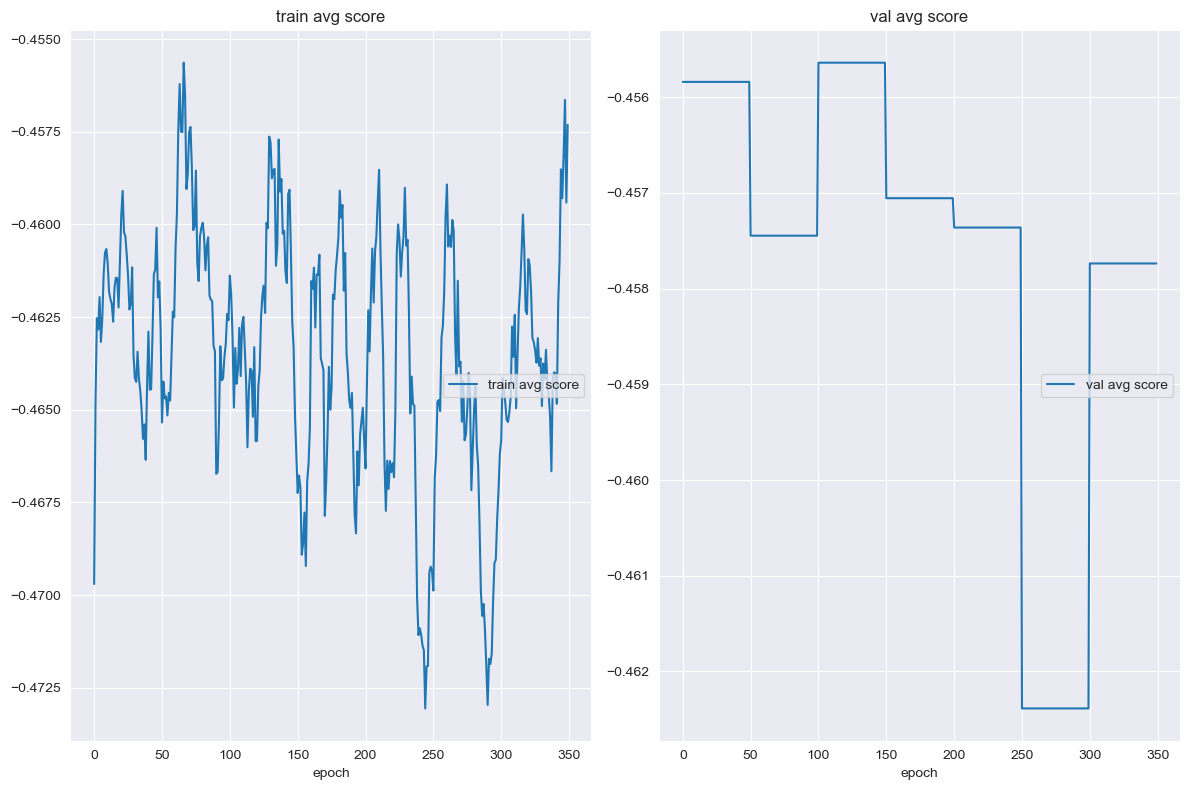

EarlyStopping counter: 5 out of 5
Early stopping


In [20]:
for layer in layers:
    finetune(layer)